# Imports

In [3]:
import numpy as np
import pandas as pd
import json
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import uncertainties.unumpy as unp
import uncertainties as unc
from datetime import date
import collections

# Functions

In [4]:
def exponential(x, a, b):
    return a * np.exp(b * x)

def exponential2(x, a, b, c):
    return a * np.exp(b*x + c*(x**2))

def weighted_exp_fit(y, cut=8, weights='linear', order=1):
    days = len(y)
    x = np.arange(days)[y > 0]
    y = y[y > 0]
    weights = np.ones(cut) #uniform weights
    if weights == 'linear':
        weights = np.arange(1, cut+1)
    if cut < len(y):
        x = x[len(y)-cut:]
        y = y[len(y)-cut:]
    else:
        weights = weights[len(weights)-len(y):]
    sigma = np.sqrt(y) / weights #linear weights become quadratic as in the least squares method a sigma^2 appears
    if len(y) < 2:
        return [0, 0], [[0, 0], [0, 0]]
    if order == 1:
        popt, pcov = curve_fit(exponential, x, y, sigma=sigma)
    elif order == 2 and len(y) == 2:
        popt = np.zeros(3)
        pcov = np.zeros((3,3))
        popt[:2], pcov[:2, :2] = curve_fit(exponential, x, y, sigma=sigma)
    elif order == 2:
        p0 = [1, 1, -0.001]
        popt, pcov = curve_fit(exponential2, x, y, sigma=sigma, maxfev=6000, p0=p0)
    return popt, pcov

def initialize_dataframe(categories, default_columns=['data', 'denominazione_regione']):
    columns = default_columns
    for c in range(len(categories)):
        columns.append(categories[c])
        columns.append('std_' + categories[c])
    return pd.DataFrame(columns=columns)

def date_list(today, days=15):
    return pd.date_range(start=today, periods=days, freq='1D')[1:]

In [5]:
oggi = str(date.today())

# Data

In [6]:
df_regions = pd.read_json('../pcm-dpc-COVID-19/dati-json/dpc-covid19-ita-regioni.json')
df_pop = pd.read_csv('dati_regioni.csv')

In [7]:
df_regions.tail()

,codice_regione,data,deceduti,denominazione_regione,dimessi_guariti,isolamento_domiciliare,lat,long,note_en,note_it,nuovi_attualmente_positivi,ricoverati_con_sintomi,stato,tamponi,terapia_intensiva,totale_attualmente_positivi,totale_casi,totale_ospedalizzati
667,9,2020-03-26T17:00:00,158,Toscana,95,1677,43.769231,11.255889,,,197,1037,ITA,20952,259,2973,3226,1296
668,4,2020-03-26T17:00:00,86,P.A. Trento,117,728,46.068935,11.121231,,,36,300,ITA,4600,66,1094,1297,366
669,10,2020-03-26T17:00:00,20,Umbria,12,580,43.106758,12.388247,,,84,144,ITA,5428,46,770,802,190
670,2,2020-03-26T17:00:00,28,Valle d'Aosta,2,281,45.737503,7.320149,,,3,73,ITA,1203,24,378,408,97
671,5,2020-03-26T17:00:00,287,Veneto,508,4367,45.434905,12.338452,,,395,1447,ITA,79759,326,6140,6935,1773


# Local exponential fit — Italian regions

In [8]:
#creating a new minimalist dataframe
df_temp = df_regions[df_regions.data == max(df_regions.data.values)]
df_temp = df_temp[df_temp.denominazione_regione != '']
df_forecast = df_temp[['data', 'codice_regione', 'denominazione_regione']].copy()
df_forecast['casi_domani'] = 0
df_forecast['std_casi_domani'] = 0
df_forecast['morti_domani'] = 0
df_forecast['std_morti_domani'] = 0
df_forecast['casi_dopodomani'] = 0
df_forecast['std_casi_dopodomani'] = 0
df_forecast['morti_dopodomani'] = 0
df_forecast['std_morti_dopodomani'] = 0

In [9]:
df_forecast.head(1)

,data,codice_regione,denominazione_regione,casi_domani,std_casi_domani,morti_domani,std_morti_domani,casi_dopodomani,std_casi_dopodomani,morti_dopodomani,std_morti_dopodomani
651,2020-03-26T17:00:00,13,Abruzzo,0,0,0,0,0,0,0,0


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sys.path[0] == '':


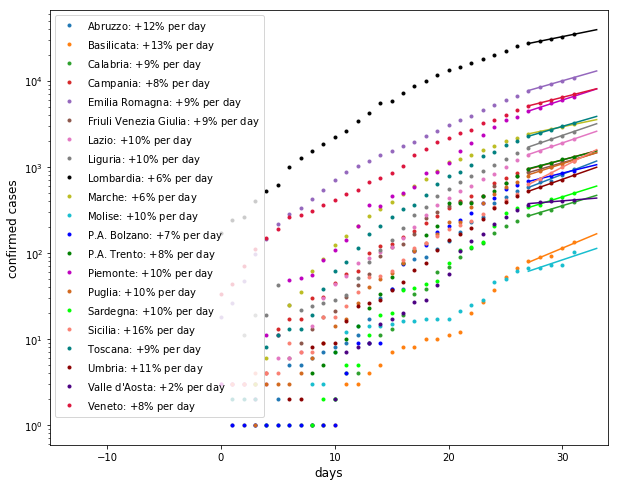

In [10]:
fig, ax = plt.subplots(figsize=(10,8))

denominazioni = np.unique(df_regions.denominazione_regione.values)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'black', 'tab:olive',
          'tab:cyan', 'b', 'g', 'm', 'chocolate',
          'lime', 'salmon', 'teal', 'darkred', 'indigo',
          'crimson'] #21 colori per VENTI regioni (mannaggia al Trentino - Alto Adige)

labels = ['casi', 'morti']
for i, den in enumerate(denominazioni):
    dfr = df_regions[df_regions.denominazione_regione == den]
    for j, y in enumerate((dfr.totale_casi.values, dfr.deceduti.values)):
        days = len(y)
        x = np.arange(days)
        cut = 5
        popt, pcov = weighted_exp_fit(y, cut=cut, weights='linear')
        a, b = unc.correlated_values(popt, pcov)
        slope = unc.nominal_value(b)
        std = unc.std_dev(b)
        xx = np.concatenate((x, [x[-1] + 1, x[-1] + 2])) #extrapolation till the day after tomorrow
        yy = a * unp.exp(b * xx[-3:])
        domani = yy[-2] - yy[-3]
        df_forecast.loc[df_forecast.denominazione_regione == den, labels[j]+'_domani'] = np.round(domani.nominal_value)
        df_forecast.loc[df_forecast.denominazione_regione == den, 'std_'+labels[j]+'_domani'] = np.round(domani.std_dev)
        dopodomani = yy[-1] - yy[-2]
        df_forecast.loc[df_forecast.denominazione_regione == den, labels[j]+'_dopodomani'] = np.round(dopodomani.nominal_value)
        df_forecast.loc[df_forecast.denominazione_regione == den, 'std_'+labels[j]+'_dopodomani'] = np.round(dopodomani.std_dev)
        
        if j == 0: #plot
            label = '{}: $+${}% per day'.format(den, int(round(slope, 2)*100))
            ax.plot(xx[days-cut:], exponential(xx[days-cut:], *popt), color=colors[i])
            ax.plot(x[y>0], y[y>0], '.', color=colors[i], label=label)
    
ax.set_yscale('log')
ax.set_ylabel('confirmed cases', fontsize='large')
ax.set_xlabel('days', fontsize='large')
ax.set_xlim(-15, days+2)
ax.legend(loc=0)

fig.savefig('plot/{}-Alberto-LocalExp-regions.png'.format(oggi), dpi = 300)

In [11]:
data_oggi = max(df_forecast.data)[:10]
df_forecast.to_csv('LocalExp_forecast_regioni_{}.csv'.format(data_oggi))

## Fit of several categories

In [180]:
categories = ['totale_casi', 'terapia_intensiva', 'deceduti']

lastdate = df_regions['data'].max()
futuredates = pd.date_range(start=lastdate, periods=15, freq='1D')[1:]

for order in [1]:
    output = collections.defaultdict(list)
    
    for i, den in enumerate(denominazioni):
        dfr = df_regions[df_regions.denominazione_regione == den]
        output['denominazione_regione'] += [den] * len(futuredates)
        output['data'] += list(futuredates)
        print(den)
        for j, category in enumerate(categories):
            y = dfr[category].values
            days = len(y)
            x = np.arange(days)
            cut = 6
            popt, pcov = weighted_exp_fit(y, cut=cut, weights='linear', order=order)
            xx = np.arange(days, days + len(futuredates))
            if order == 1:
                a, b = unc.correlated_values(popt, pcov)
                yy = a * unp.exp(b * xx)
            elif order == 2:
                a, b, c = unc.correlated_values(popt, pcov)
                yy = a * unp.exp(b * xx + c * xx**2)
            output[category] += list(unp.nominal_values(yy))
            output['std_' + category] += list(unp.std_devs(yy))
        
    df_predictions = pd.DataFrame(output)
    directory = f'../predictions/{lastdate[:10]}/dati-regioni'
    path = f'{directory}/model-LocalExp-order{str(order)}.csv'
    df_predictions.to_csv(path, index=False)

Abruzzo
Basilicata
Calabria
Campania
Emilia Romagna
Friuli Venezia Giulia
Lazio
Liguria
Lombardia
Marche
Molise
P.A. Bolzano
P.A. Trento


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sys.path[0] == '':


Piemonte
Puglia
Sardegna
Sicilia
Toscana
Umbria
Valle d'Aosta
Veneto
